[View in Colaboratory](https://colab.research.google.com/github/nakamura41/emotion_detection_notebooks/blob/master/CrowdFlower_Emotion_Analysis_ConvNet.ipynb)

In [1]:
!pip install gensim
!pip install -U -q PyDrive
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.3.3)


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

RANDOM_STATE = 41

print(tf.__version__)

1.10.1


Using TensorFlow backend.


In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [5]:
download_drive_file("Datasets", "GoogleNews-vectors-negative300.bin.gz")

downloading file GoogleNews-vectors-negative300.bin.gz


In [6]:
!ls

adc.json  GoogleNews-vectors-negative300.bin.gz  sample_data


In [0]:
class CrowdFlowerDataset(object):
  BASE_URL = "https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv"
  EMOTION_CLASSES = ["anger", "boredom", "empty", "enthusiasm", "fun", "happiness", "hate", "love", "neutral", "relief", "sadness", "surprise", "worry"]
  RANDOM_STATE = 41
  
  # based on Parrott's emotions group
  EMOTION_MAPPING = {
      "anger": "anger",
      "boredom": "sadness",
      "empty": "sadness",
      "enthusiasm": "joy",
      "fun": "joy",
      "happiness": "joy",
      "hate": "anger",
      "love": "love",
      "neutral": "neutral",
      "relief": "joy",
      "sadness": "sadness",
      "surprise": "joy",
      "worry": "worry"
  }
  
  def __load_data_url(self, url):
    df = pd.read_csv(url)
    df["text"] = df["content"]
    df["emotion"] = df["sentiment"]
    df = df[df.emotion != "neutral"]
    return df[["text", "emotion"]]
  
  def __emotion_mapping(self, data):
    new_data = data
    for emotion in self.EMOTION_CLASSES:
      new_data.loc[data.emotion == emotion, "emotion"] = self.EMOTION_MAPPING[emotion]
    return new_data
    
  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_url(self.BASE_URL)
    data = self.__emotion_mapping(data)
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

{'sadness': 0, 'joy': 1, 'worry': 2, 'love': 3, 'anger': 4}
['sadness', 'joy', 'worry', 'love', 'anger']


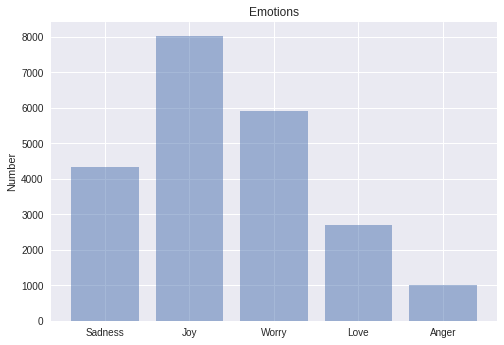

In [9]:
crowd_flower_dataset = CrowdFlowerDataset()
train_data, test_data = crowd_flower_dataset.load_data()

emotions = train_data.emotion.unique()
dic = dict()
labels = []
for i, emotion in enumerate(emotions):
    dic[emotion]=i
    labels.append(emotion)
print(dic)
print(labels)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]
  
num_bins = 5
bins = [0,1,2,3,4,5]
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

objects = ('Sadness', 'Joy', 'Worry', 'Love', 'Anger')
y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

The training data is very imbalanced!

### Tokenize training and test dataset

In [10]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31065 unique tokens.


In [11]:
X_train_unbalanced = pad_sequences(sequences_train)
X_test = pad_sequences(sequences_test, maxlen=X_train_unbalanced.shape[1])

y_train_unbalanced = np.asarray(train_data.emotion.apply(lambda x:dic[x]))
y_test = np.asarray(test_data.emotion.apply(lambda x:dic[x]))

print('Shape of X train and test tensor:', X_train_unbalanced.shape, X_test.shape)
print('Shape of label train and test tensor:', y_train_unbalanced.shape, y_test.shape)

Shape of X train and test tensor: (21953, 36) (9409, 36)
Shape of label train and test tensor: (21953,) (9409,)


### Balance Training dataset using SMOTE

In [12]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using SMOTE:', X_train_smote.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_smote)))

Shape of X train tensor which is balanced using SMOTE: (40100, 36)
Original label shape Counter({1: 8020, 2: 5921, 0: 4320, 3: 2689, 4: 1003})
Resampled label shape Counter({0: 8020, 1: 8020, 2: 8020, 3: 8020, 4: 8020})


### Balance Training dataset using Random Over Sampler

In [13]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_ros, y_train_ros = ros.fit_sample(X_train_unbalanced, y_train_unbalanced)

print('Shape of X train tensor which is balanced using ROS:', X_train_ros.shape)
print('Original label shape {}'.format(Counter(y_train_unbalanced)))
print('Resampled label shape {}'.format(Counter(y_train_ros)))

Shape of X train tensor which is balanced using ROS: (40100, 36)
Original label shape Counter({1: 8020, 2: 5921, 0: 4320, 3: 2689, 4: 1003})
Resampled label shape Counter({0: 8020, 1: 8020, 2: 8020, 3: 8020, 4: 8020})


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_ros, y_train_ros, test_size=0.1, random_state=RANDOM_STATE, stratify=y_train_ros)

print('y_train {}'.format(Counter(y_train)))
print('y_val {}'.format(Counter(y_val)))
print('y_test {}'.format(Counter(y_test)))

y_train Counter({4: 7218, 2: 7218, 3: 7218, 0: 7218, 1: 7218})
y_val Counter({4: 802, 1: 802, 3: 802, 0: 802, 2: 802})
y_test Counter({1: 3437, 2: 2538, 0: 1851, 3: 1153, 4: 430})


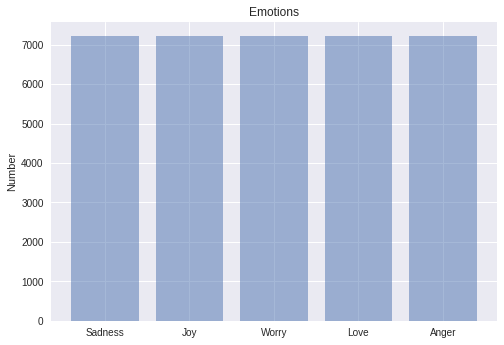

In [15]:
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

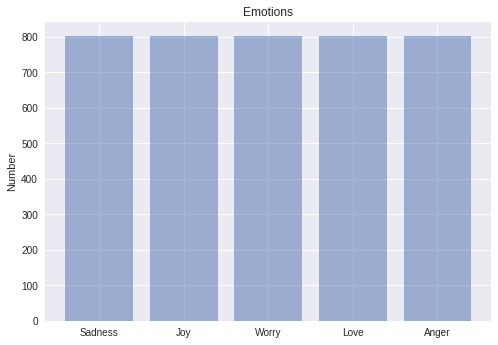

In [16]:
hist, _ = np.histogram(y_val, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

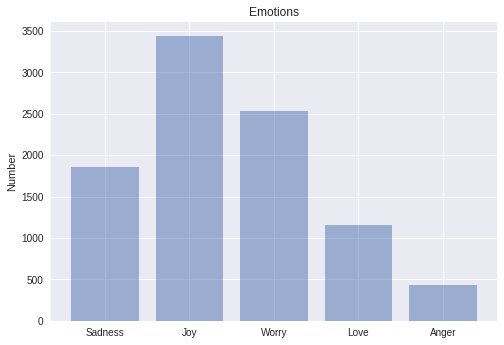

In [17]:
hist, _ = np.histogram(y_test, bins=bins)

y_pos = np.arange(len(objects))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [18]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (36090, 36) (4010, 36) (9409, 36)
Shape of label train, validation and test tensor: (36090, 5) (4010, 5) (9409, 5)


In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [20]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop_rate = 0.5
n_class = 5

print(sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1), name='reshape_1')(embedding)

conv_1 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_1')(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_2')(reshape)
conv_3 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu',kernel_regularizer=regularizers.l2(0.01), name='conv_3')(reshape)

maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=1, name='maxpool_1')(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=1, name='maxpool_2')(conv_2)
maxpool_3 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=1, name='maxpool_3')(conv_3)

merged_tensor = concatenate([maxpool_1, maxpool_2, maxpool_3], axis=1, name='concatenate_1')
flatten = Flatten()(merged_tensor)
dropout = Dropout(drop_rate, name='dropout_1')(flatten)
output = Dense(units=n_class, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name='dense_1')(dropout)

# this creates a model that includes
model = Model(inputs, output)

model.summary()

36
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 36, 300, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 34, 1, 100)   90100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_2 

In [21]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(X_train, y_train, batch_size=1000, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 36090 samples, validate on 4010 samples
Epoch 1/100
36090/36090 [==============================] - 7s 206us/step - loss: 1.6161 - acc: 0.3815 - val_loss: 1.4707 - val_acc: 0.4920
Epoch 2/100
36090/36090 [==============================] - 5s 135us/step - loss: 1.4079 - acc: 0.5153 - val_loss: 1.3448 - val_acc: 0.5494
Epoch 3/100
36090/36090 [==============================] - 5s 134us/step - loss: 1.3035 - acc: 0.5700 - val_loss: 1.2768 - val_acc: 0.5781
Epoch 4/100
36090/36090 [==============================] - 5s 137us/step - loss: 1.2292 - acc: 0.6072 - val_loss: 1.2164 - val_acc: 0.6120
Epoch 5/100
36090/36090 [==============================] - 5s 136us/step - loss: 1.1689 - acc: 0.6402 - val_loss: 1.1765 - val_acc: 0.6304
Epoch 6/100
36090/36090 [==============================] - 5s 134us/step - loss: 1.1193 - acc: 0.6715 - val_loss: 1.1481 - val_acc: 0.6486
Epoch 7/100
36090/36090 [==============================] - 5s 135us/step - loss: 1.0738 - acc: 0.7023 - val_loss: 1.1

In [0]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

In [23]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [26]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,sadness,joy,worry,love,anger
sadness,606,396,633,99,117
joy,547,1534,787,480,89
worry,625,581,1048,157,127
love,135,339,187,465,27
anger,118,70,146,13,83


Figure(288x216)


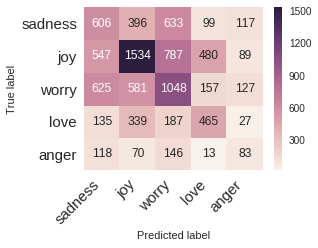

In [27]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [28]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.397066638325008


### Performance score for each classes

In [29]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,f1-score,precision,recall,support
sadness,0.1901,0.1874,0.1930,430
joy,0.4826,0.5253,0.4463,3437
worry,0.3929,0.3830,0.4033,1153
love,0.3122,0.2984,0.3274,1851
anger,0.3926,0.3742,0.4129,2538


### Performance score using micro average

In [30]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.3971,0.3971,0.3971,None


### Performance score using macro average

In [31]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.3541,0.3537,0.3566,None


### Performance score using weighted average

In [32]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.4004,0.407,0.3971,None
